# 5
## 5.3
### 5.3.1

In [4]:
# List 5-16

from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [5]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

#### データ拡張を行わない高速な特徴抽出

In [6]:
# List 5-17
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = '/home/takao/Documents/dev/jupyter/DL-By-Python-Keras/5-cat_and_dog_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory,
                                            target_size=(150, 150),
                                            batch_size=batch_size,
                                            class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if(i * batch_size >= sample_count):
            break;
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [7]:
train_features = np.reshape(train_features, (2000, 4*4*512))
validation_features = np.reshape(validation_features, (1000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4*4*512))

In [8]:
# List 5-18

from tensorflow.keras import models, layers, optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

W0816 17:29:27.729628 140379431780480 deprecation.py:323] From /home/takao/.pyenv/versions/3.7.4/envs/Jupyter/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 423us/sample - loss: 0.5899 - acc: 0.6830 - val_loss: 0.4457 - val_acc: 0.8430
Epoch 2/30
2000/2000 [==============================] - 1s 286us/sample - loss: 0.4241 - acc: 0.8010 - val_loss: 0.3687 - val_acc: 0.8500
Epoch 3/30
2000/2000 [==============================] - 1s 323us/sample - loss: 0.3572 - acc: 0.8490 - val_loss: 0.3242 - val_acc: 0.8840
Epoch 4/30
2000/2000 [==============================] - 1s 288us/sample - loss: 0.3146 - acc: 0.8625 - val_loss: 0.3018 - val_acc: 0.8880
Epoch 5/30
2000/2000 [==============================] - 1s 317us/sample - loss: 0.2914 - acc: 0.8820 - val_loss: 0.2862 - val_acc: 0.8980
Epoch 6/30
2000/2000 [==============================] - 1s 300us/sample - loss: 0.2627 - acc: 0.8960 - val_loss: 0.2799 - val_acc: 0.8910
Epoch 7/30
2000/2000 [==============================] - 1s 289us/sample - loss: 0.2550 - acc: 0.8930 - val_loss: 0.2665 - va

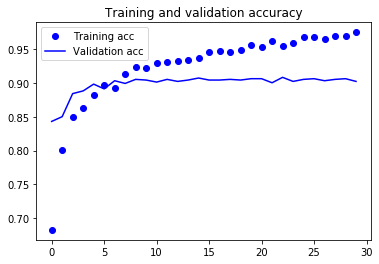

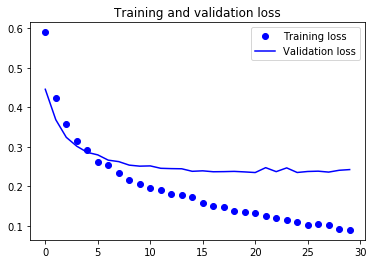

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### データ拡張を行う特徴抽出

In [10]:
# List 5-20

from tensorflow.keras import models, layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [12]:
print('これゎ、conv_base を凍結する前の、訓練する重みの数', len(model.trainable_weights))

これゎ、conv_base を凍結する前の、訓練する重みの数 30


In [13]:
conv_base.trainable = False

In [14]:
print('これゎ、conv_base を凍結した後の、訓練する重みの数', len(model.trainable_weights))

これゎ、conv_base を凍結した後の、訓練する重みの数 4


In [15]:
# List 5-21

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    class_mode='binary')
validation_generator = test_datagen.flow_from_directory(train_dir,
                                                        target_size=(150, 150),
                                                        batch_size=20,
                                                        class_mode='binary')

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=30,
                              validation_data=validation_generator,
                              validation_steps=50,
                              verbose=2)

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/30
100/100 - 22s - loss: 0.5753 - acc: 0.7135 - val_loss: 0.4397 - val_acc: 0.8290
Epoch 2/30
100/100 - 20s - loss: 0.4823 - acc: 0.7810 - val_loss: 0.3453 - val_acc: 0.8760
Epoch 3/30
100/100 - 20s - loss: 0.4310 - acc: 0.8195 - val_loss: 0.3036 - val_acc: 0.8850
Epoch 4/30
100/100 - 20s - loss: 0.4023 - acc: 0.8315 - val_loss: 0.2775 - val_acc: 0.8970
Epoch 5/30
100/100 - 20s - loss: 0.3864 - acc: 0.8245 - val_loss: 0.2637 - val_acc: 0.9030
Epoch 6/30
100/100 - 20s - loss: 0.3625 - acc: 0.8445 - val_loss: 0.2558 - val_acc: 0.8950
Epoch 7/30
100/100 - 20s - loss: 0.3545 - acc: 0.8495 - val_loss: 0.2418 - val_acc: 0.9010
Epoch 8/30
100/100 - 20s - loss: 0.3535 - acc: 0.8420 - val_loss: 0.2323 - val_acc: 0.9080
Epoch 9/30
100/100 - 20s - loss: 0.3372 - acc: 0.8440 - val_loss: 0.2268 - val_acc: 0.9070
Epoch 10/30
100/100 - 20s - loss: 0.3382 - acc: 0.8540 - val_loss: 0.2186 - val_acc: 0.9090
Epoch

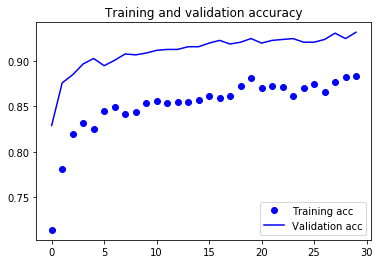

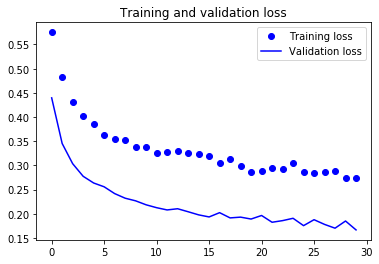

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 5.3.2

In [17]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [18]:
# List 5-22

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [19]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=100,
                              validation_data=validation_generator,
                              validation_steps=50)

Epoch 1/100
100/100 [==============================] - 26s 255ms/step - loss: 0.3006 - acc: 0.8705 - val_loss: 0.1410 - val_acc: 0.9420
Epoch 2/100
100/100 [==============================] - 26s 258ms/step - loss: 0.2627 - acc: 0.8875 - val_loss: 0.1207 - val_acc: 0.9510
Epoch 3/100
100/100 [==============================] - 25s 246ms/step - loss: 0.2488 - acc: 0.8975 - val_loss: 0.1352 - val_acc: 0.9490
Epoch 4/100
100/100 [==============================] - 26s 256ms/step - loss: 0.2105 - acc: 0.9110 - val_loss: 0.1312 - val_acc: 0.9550
Epoch 5/100
100/100 [==============================] - 27s 265ms/step - loss: 0.2161 - acc: 0.9080 - val_loss: 0.0990 - val_acc: 0.9590
Epoch 6/100
100/100 [==============================] - 25s 249ms/step - loss: 0.2020 - acc: 0.9210 - val_loss: 0.0933 - val_acc: 0.9650
Epoch 7/100
100/100 [==============================] - 26s 255ms/step - loss: 0.1756 - acc: 0.9265 - val_loss: 0.0731 - val_acc: 0.9720
Epoch 8/100
100/100 [===========================

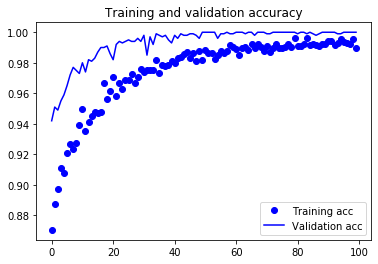

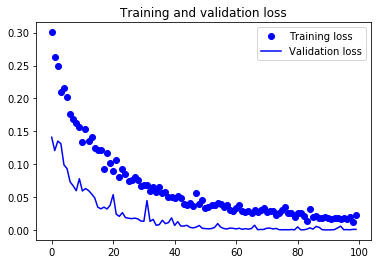

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

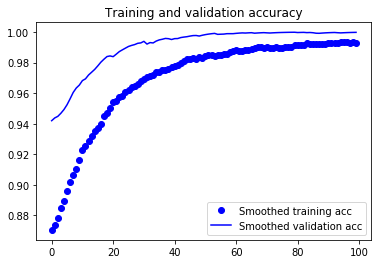

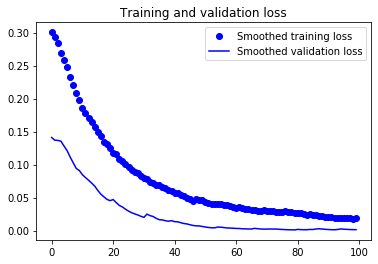

In [21]:
def smooth_curve(points, factor=0.8):
    smoothed_points=[]
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous*factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [22]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(150,150),
                                                  batch_size=20,
                                                  class_mode='binary')
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test_acc', test_acc)

Found 1000 images belonging to 2 classes.
test_acc 0.937
